In [41]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Loading in data 
adj =  np.genfromtxt('Inputs/adj.csv', delimiter=',', dtype=np.int8)
data = np.genfromtxt('Inputs/data.csv', delimiter=',')

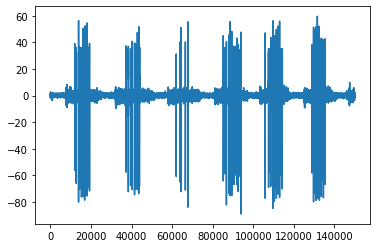

In [45]:
# Plotting the first channel 
plt.plot(data[:,1])
plt.show()

In [46]:
# Figuring out how to generate dummy data

# Sinusodal data
def gen_dummy_data():
    # TODO: Paramterize this so it can change size, perhaps function o_O
    return np.asarray([np.sin(np.arange(0,100,.1))]*16).transpose()
    
def gen_dummy_adj():
    # TODO: No clue, this is hard coded
    tmp = []
    for i in range(1,16,2):
        tmp.append([i-1, i])
        tmp.append([i, i-1])
    return np.asarray(tmp)


In [217]:
# Generating dummy data with unique spike templates 

# Generating spike times 
def gen_spike_times(N, lim, numSpks, numChans):
    np.random.seed(1738)
    spkTimes = []
    spkChans = []
    for i in range(numSpks):
        spkTimes.append(np.random.choice(range(lim), N, replace = False))
        spkChans.append(np.random.choice(range(numChans), N, replace=True))
    return np.asarray(spkTimes), np.asarray(spkChans)

# Generating spike template
def gen_spike_template(numSpks,muWidth=90,sigmaWidth=10, muFac=0.1, sigmaFac=0.02):
    from scipy import signal 
    np.random.seed(1738)
    
    waveforms = []
    
    for i in range(numSpks):
        width = sigmaWidth * np.random.randn() + muWidth 
        factor = (np.abs(sigmaFac*np.random.randn()+muFac))*width
        polarity = np.random.choice([1,-1], 1)[0]
        waveforms.append(polarity*signal.ricker(width, factor))
    return np.asarray(waveforms, dtype=object)
a = gen_spike_template(16)

In [198]:
# Plotting of waveforms 
def plot_waveforms(wave):
    fig, axs = plt.subplots(4,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.grid=True
    
    # Loop variables 
    count, minY, maxY = 0, float('inf'), -float('inf') 
    
    for i in range(4):
        for j in range(4):
            axs[i][j].plot(wave[count])
            count += 1
            minY = min(min(a[0]),minY)
            maxY = max(max(a[0]),maxY)
    
    # Updating Y scale 
    for i in range(4):
        for j in range(4):
            axs[i][j].set_ylim((minY-1, maxY+1))
    
    plt.show()
    return fig, axs

In [219]:
tmp, bruh = gen_spike_times(10,100,10,16)
tmp

array([[62,  3, 20, 63, 58, 13,  1, 99, 65, 37],
       [29, 61, 71, 49, 31, 56, 88, 79, 78, 83],
       [41, 15, 65, 24, 66, 25, 46, 30, 14, 20],
       [78, 36, 39, 42, 34,  1, 37, 21, 71, 96],
       [42, 70, 31, 21, 35, 16,  3, 45, 19, 74],
       [88, 11, 97, 95, 72, 23, 14, 75, 98, 52],
       [54, 35, 11, 47, 37, 43, 75, 46, 14,  0],
       [58, 61,  7, 79, 41, 20, 17, 13,  9, 50],
       [86, 79, 92, 12, 46, 89, 81, 37, 80, 60],
       [89, 98, 18, 32, 53, 12, 91, 74, 65, 95]])